In [16]:
import warnings
warnings.filterwarnings("ignore")
# from sklearn.preprocessing import StandardScalar
from utilities import *

In [17]:
label_avocado_hass,sequence_avocado_hass = readFastaFiles("Avocado_Hass_proteins.fasta")


In [18]:
len(label_avocado_hass)

12406

In [19]:
result_signalp_avocado_hass = resultSignalP("avocado_hass_signalp/prediction_results.txt")

In [20]:
unique, counts = np.unique(result_signalp_avocado_hass, return_counts=True)

In [21]:
print(np.asarray((unique, counts)).T)

[[    0 11709]
 [    1   697]]


In [22]:
#tape_data
avocado_hass_ebedding = np.load('embedding_avocado_hass.npy')

In [23]:
avocado_hass_ebedding.shape

(12406, 768)

In [24]:
#ESM
embed2_avocado_hass = torch.load('embed2_avocado_hass.pt')

In [25]:
numpy_array_list = [tensor.numpy() for tensor in embed2_avocado_hass]
numpy_embed2_avocado_hass = np.array(numpy_array_list)

In [26]:
numpy_embed2_avocado_hass.shape

(12406, 1, 1280)

In [27]:
avocado_hass_ebedding2 = numpy_embed2_avocado_hass.reshape(numpy_embed2_avocado_hass.shape[0],numpy_embed2_avocado_hass.shape[2])


In [28]:
avocado_hass_ebedding2.shape

(12406, 1280)

In [29]:
len(embed2_avocado_hass)

12406

In [30]:
embedding_padded = np.concatenate((avocado_hass_ebedding, np.zeros((avocado_hass_ebedding.shape[0],16))), axis=1)
embedding2_padded = np.concatenate((avocado_hass_ebedding2, np.zeros((avocado_hass_ebedding2.shape[0],16))), axis=1)

In [31]:
shape_unit=28
embedding_images=np.reshape(embedding_padded,(embedding_padded.shape[0],shape_unit,shape_unit))

print(embedding_images.shape)

(12406, 28, 28)


In [32]:
shape_unit=36
embedding2_images=np.reshape(embedding2_padded,(embedding2_padded.shape[0],shape_unit,shape_unit))

print(embedding2_images.shape)

(12406, 36, 36)


In [33]:
embedding_geotop = geotop_analysis(embedding_images)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [34]:
#28*28
np.savez("embedding_geotop_avocado_hass.npz", *embedding_geotop)

In [35]:
#36*36
embedding2_geotop = geotop_analysis(embedding2_images)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [36]:
np.savez("embedding2_geotop_avocado_hass.npz", *embedding2_geotop)

## Trainning

In [37]:
dgms = gdr.DiagramSelector(use=True, point_type='finite').fit_transform(embedding_geotop)

In [38]:
dim = 1024
result = concate_embedding_geotop(avocado_hass_ebedding,dgms,dim)

In [39]:
#splitting the dataset
num_samples = len(result)
num_train_samples = int(0.8 * num_samples)  # 80% for training, 20% for testing

# Split data and labels into training and testing sets
train_data, test_data = result[:num_train_samples], result[num_train_samples:]
train_labels, test_labels = result_signalp_avocado_hass[:num_train_samples], result_signalp_avocado_hass[num_train_samples:]

In [40]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [41]:
shape_unit=32
std_scale = skp.StandardScaler().fit(train_data)
X_normalized = std_scale.transform(train_data)
train_data=np.reshape(X_normalized,(X_normalized.shape[0],shape_unit,shape_unit))

In [42]:
std_scale = skp.StandardScaler().fit(test_data)
X_normalized = std_scale.transform(test_data)
test_data=np.reshape(X_normalized,(X_normalized.shape[0],shape_unit,shape_unit))

In [43]:
train_data = np.expand_dims(train_data, -1)
test_data = np.expand_dims(test_data, -1)

In [44]:
unique, counts = np.unique(train_labels, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 9302]
 [   1  622]]


In [45]:
train_data.shape

(9924, 32, 32, 1)

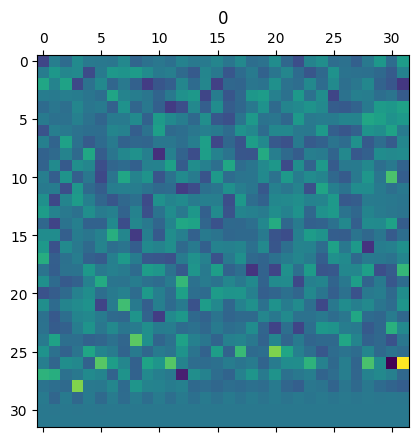

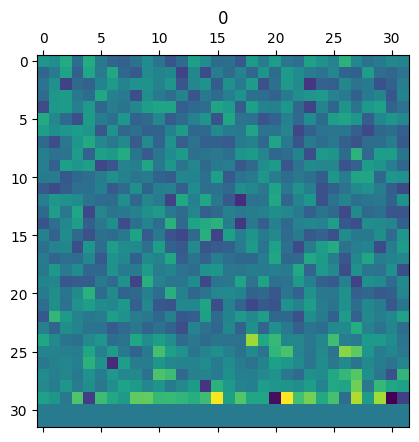

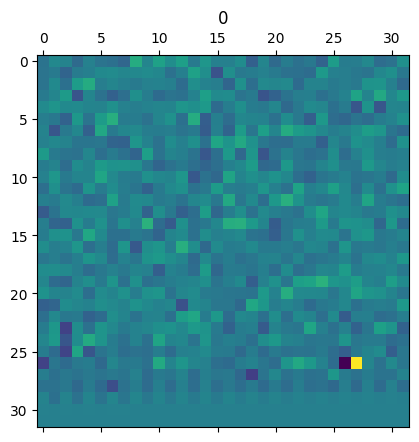

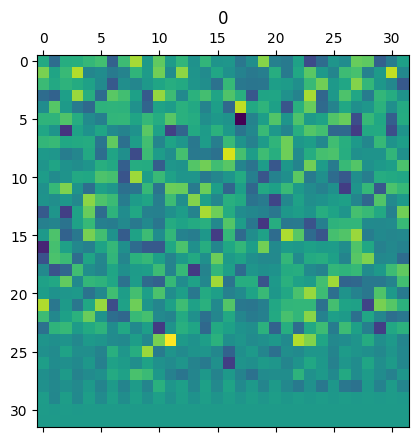

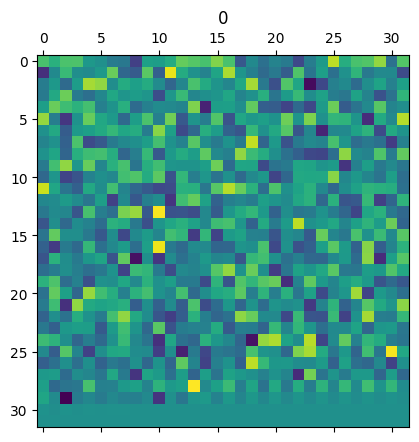

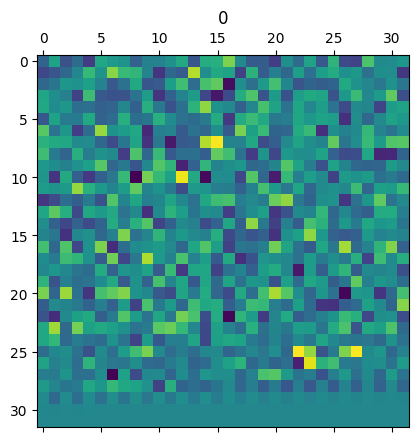

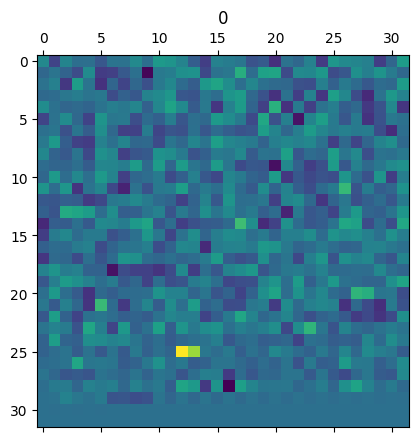

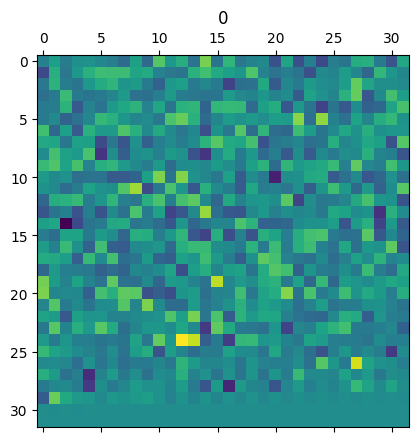

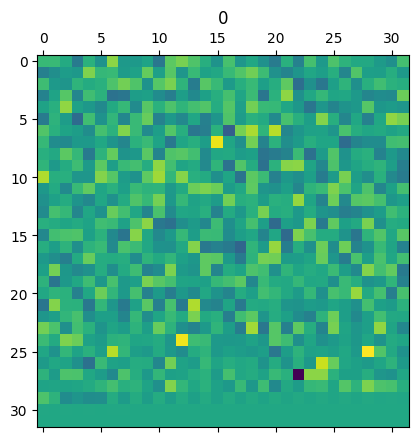

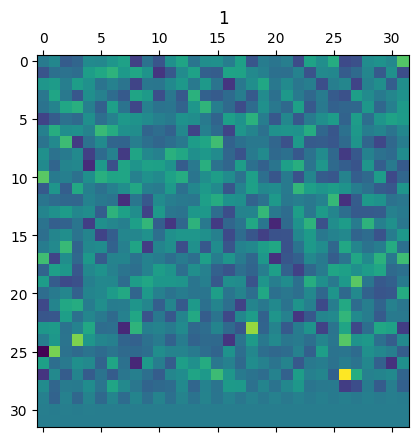

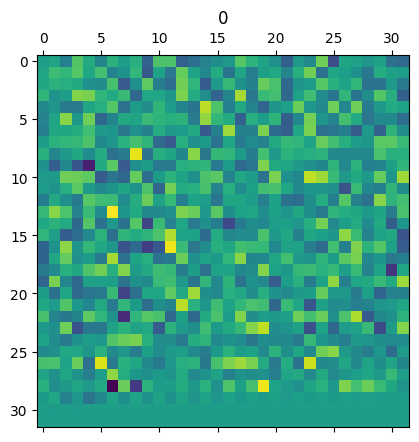

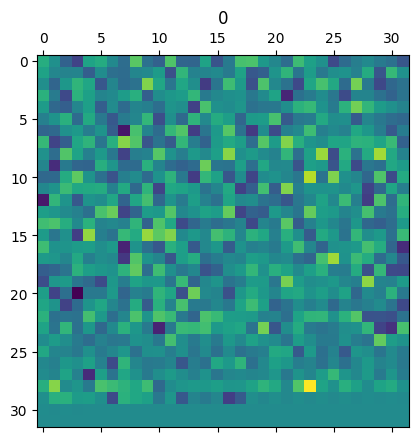

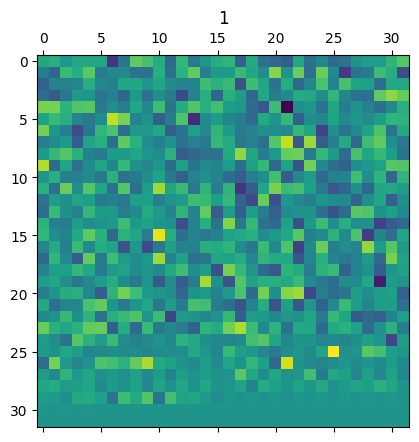

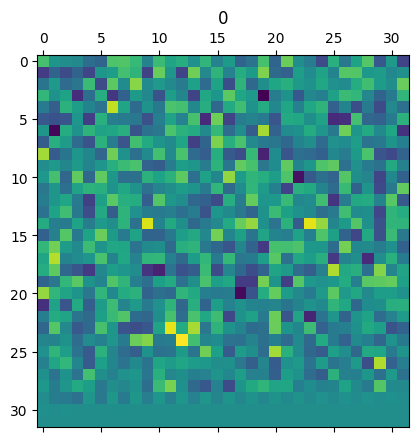

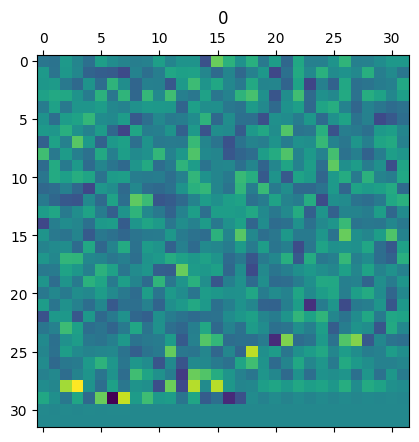

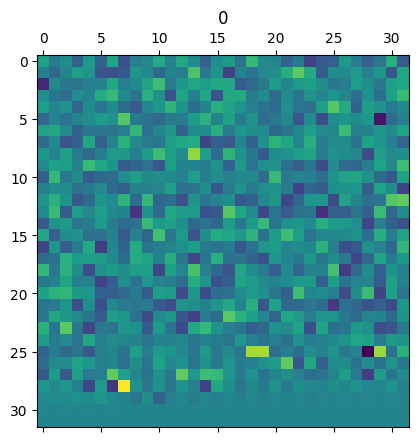

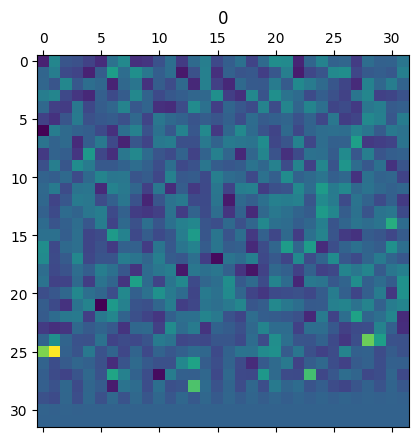

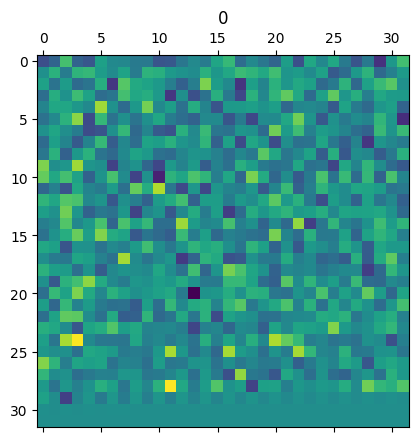

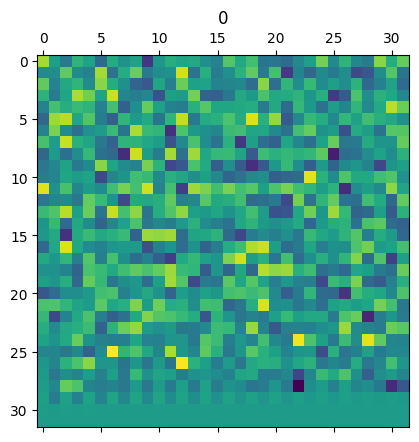

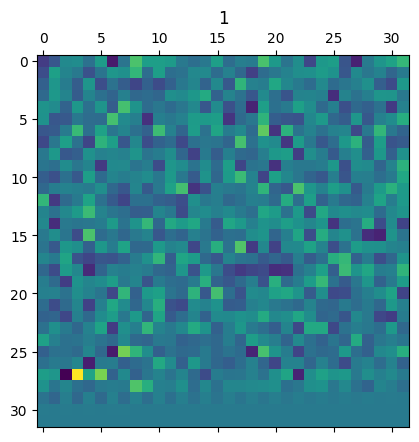

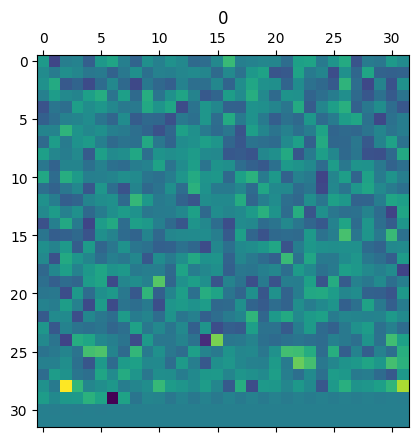

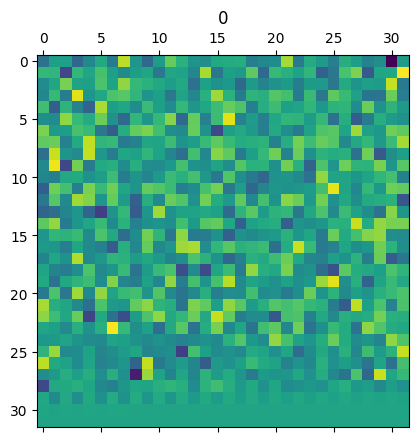

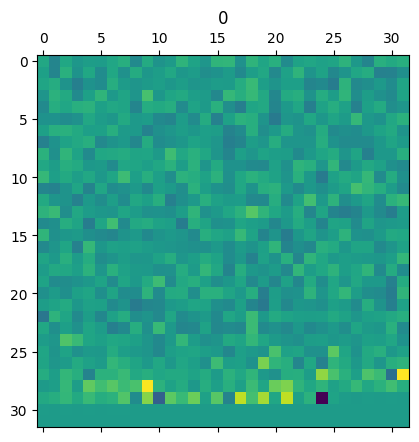

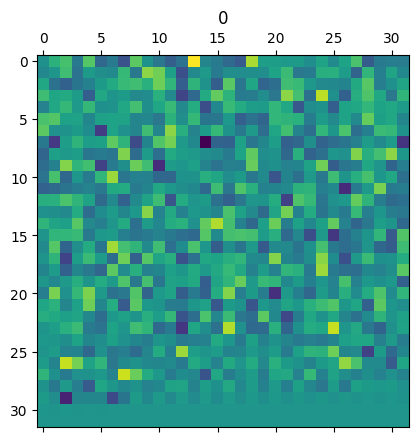

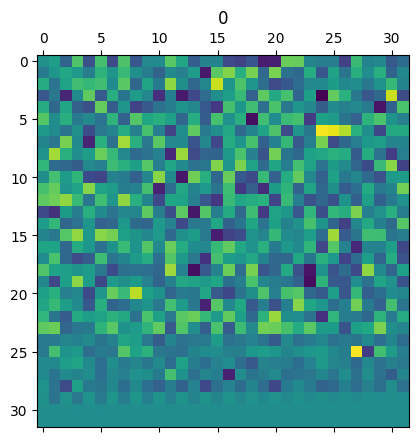

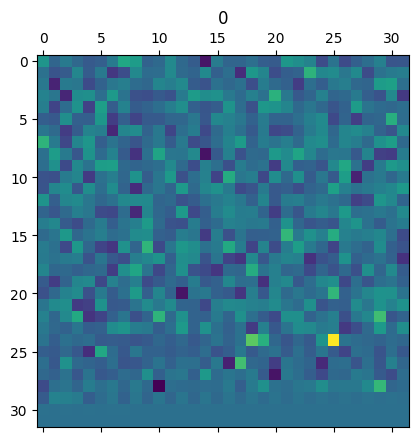

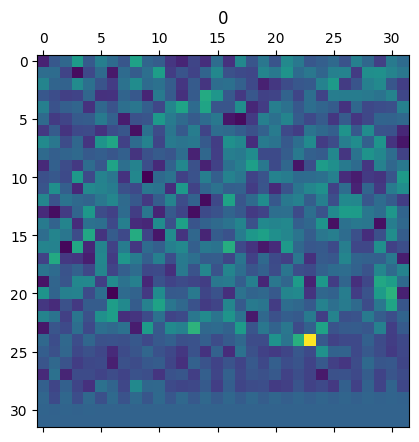

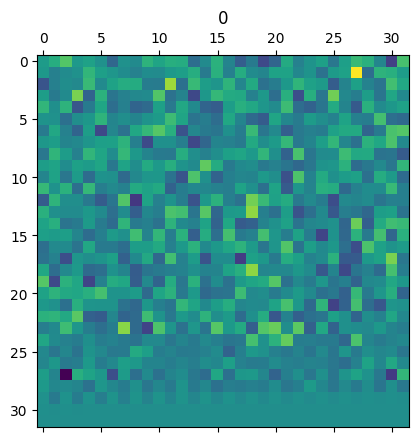

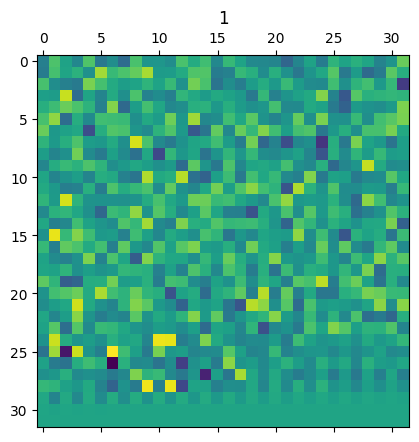

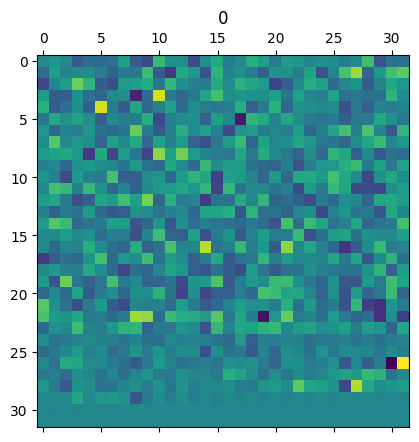

In [46]:
for i in range(30):
    plt.matshow(train_data[i])
    plt.title(train_labels[i])
    plt.show()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         80        
                                                                 
 average_pooling2d (Average  (None, 16, 16, 8)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 average_pooling2d_1 (Avera  (None, 8, 8, 16)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 average_pooling2d_2 (Avera  (None, 4, 4, 32)        

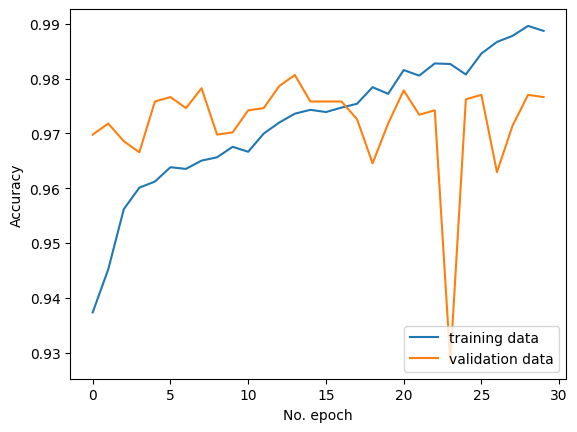

In [47]:
 model_trainning_saving([32,32],30,"tape_model_avocado_hass",train_data,train_labels,test_data,test_labels)

# ESM and Geotop

In [48]:
dgms = gdr.DiagramSelector(use=True, point_type='finite').fit_transform(embedding2_geotop)

In [49]:
dim = 1681
result = concate_embedding_geotop(avocado_hass_ebedding2,dgms,dim)

In [50]:
#splitting the dataset
num_samples = len(result)
num_train_samples = int(0.8 * num_samples)  # 80% for training, 20% for testing

# Split data and labels into training and testing sets
train_data, test_data = result[:num_train_samples], result[num_train_samples:]
train_labels, test_labels = result_signalp_avocado_hass[:num_train_samples], result_signalp_avocado_hass[num_train_samples:]

In [51]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [52]:
shape_unit=41
std_scale = skp.StandardScaler().fit(train_data)
X_normalized = std_scale.transform(train_data)
train_data=np.reshape(X_normalized,(X_normalized.shape[0],shape_unit,shape_unit))

In [53]:
std_scale = skp.StandardScaler().fit(test_data)
X_normalized = std_scale.transform(test_data)
test_data=np.reshape(X_normalized,(X_normalized.shape[0],shape_unit,shape_unit))

In [54]:
train_data = np.expand_dims(train_data, -1)
test_data = np.expand_dims(test_data, -1)

In [55]:
unique, counts = np.unique(train_labels, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 9302]
 [   1  622]]


In [56]:
train_data.shape

(9924, 41, 41, 1)

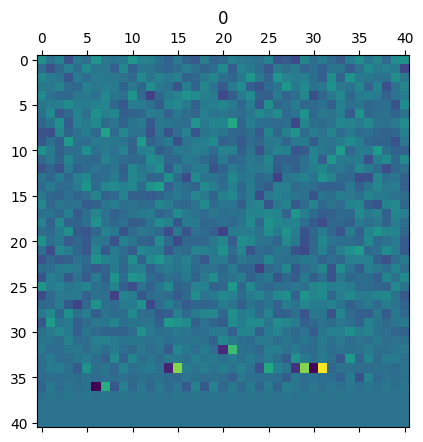

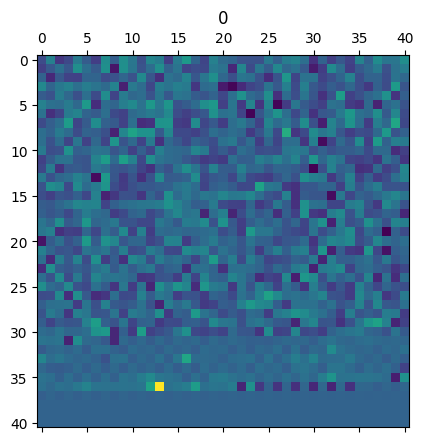

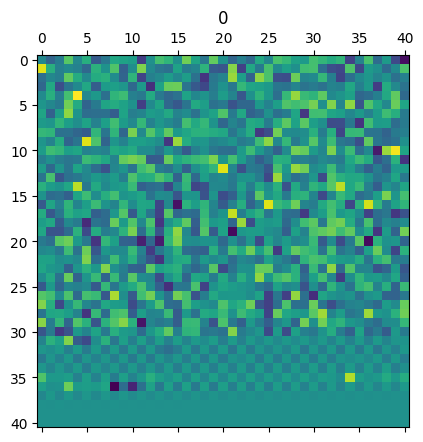

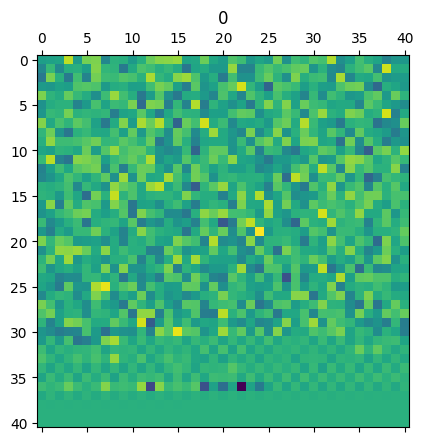

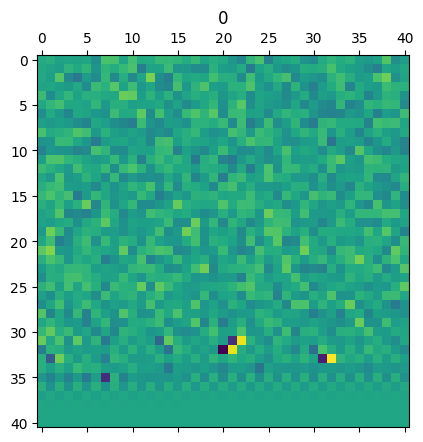

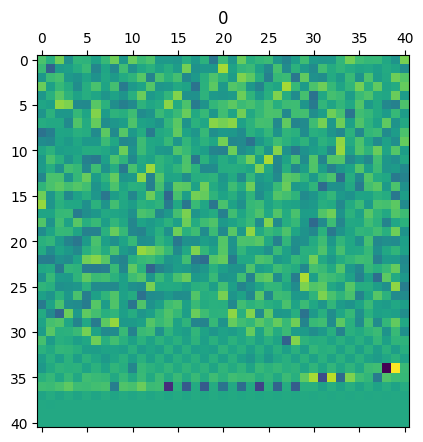

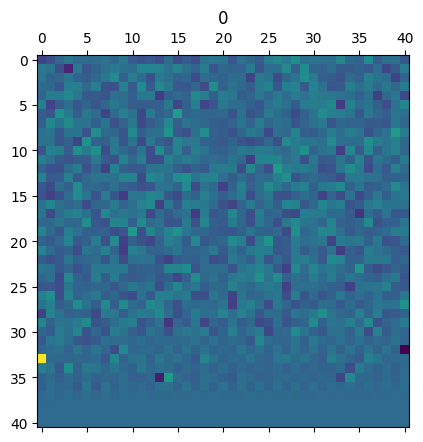

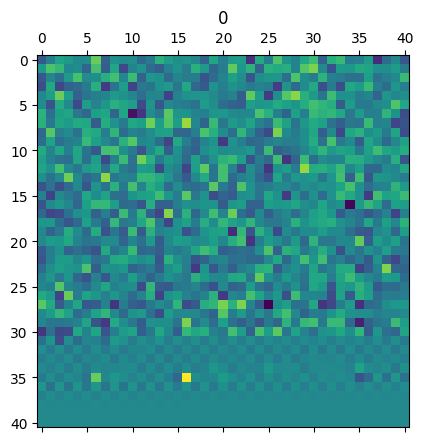

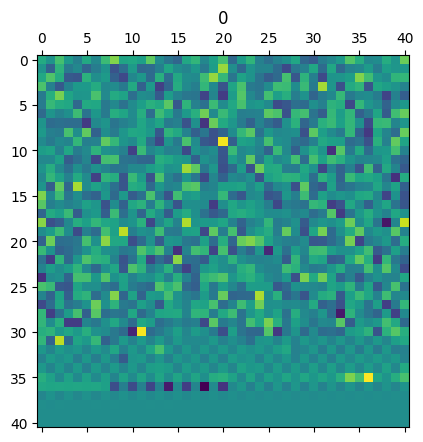

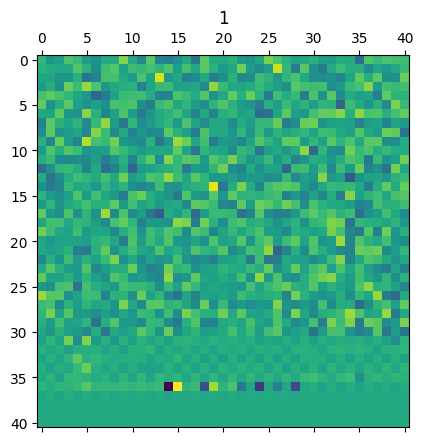

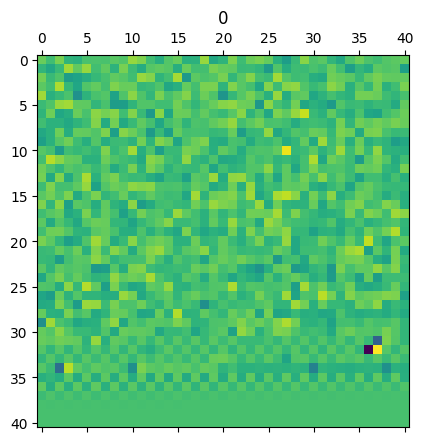

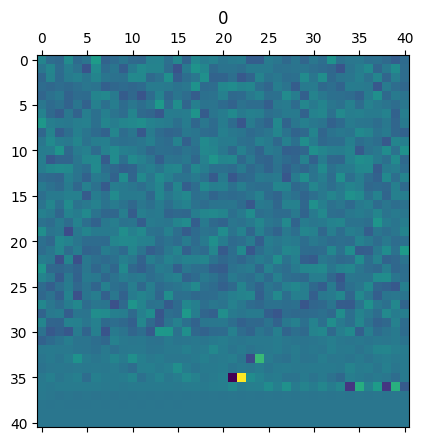

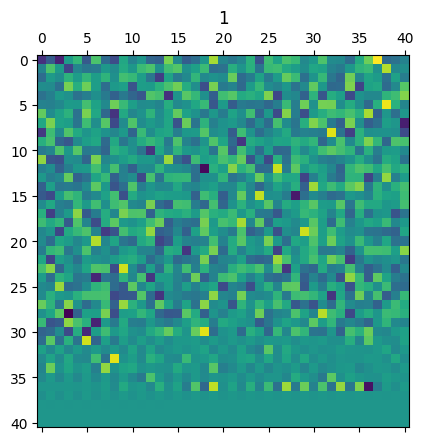

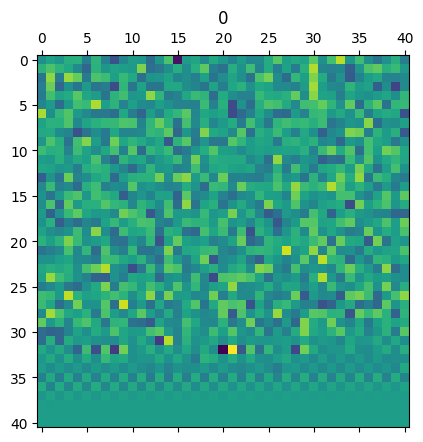

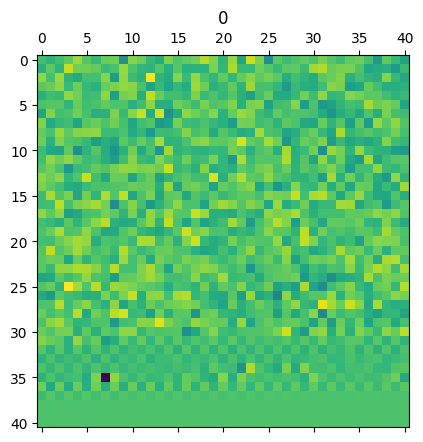

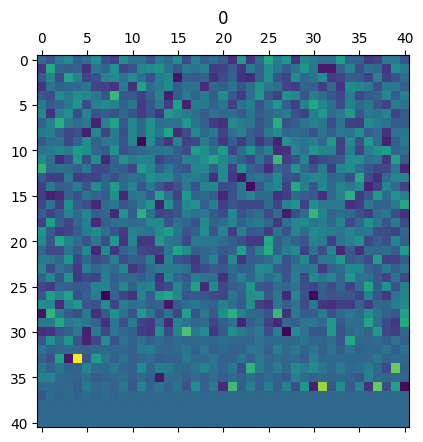

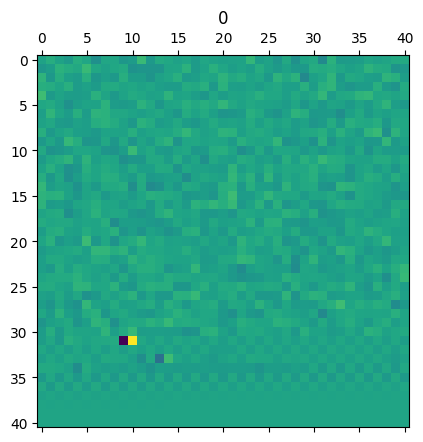

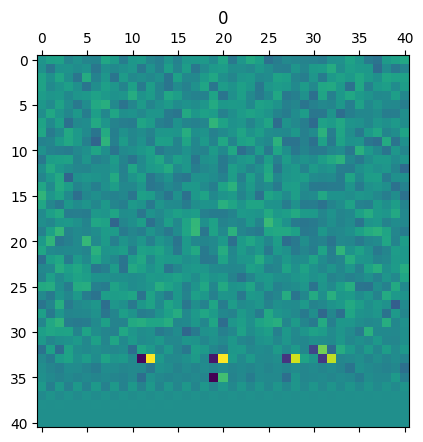

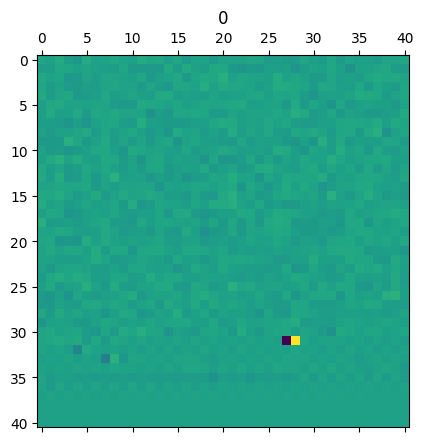

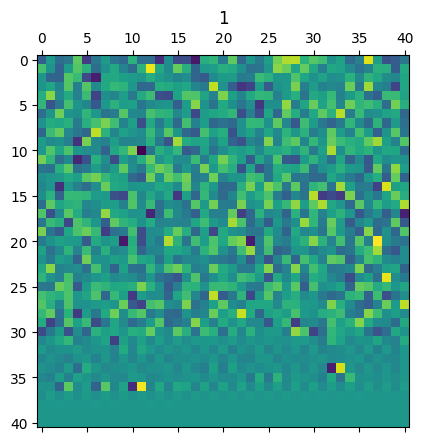

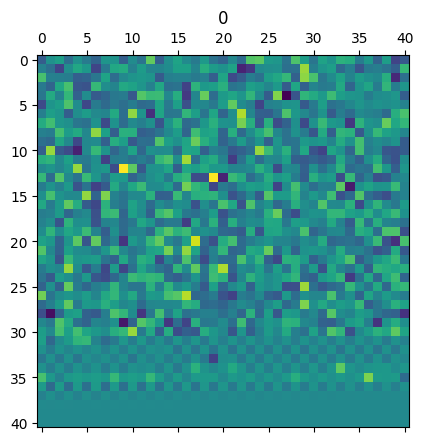

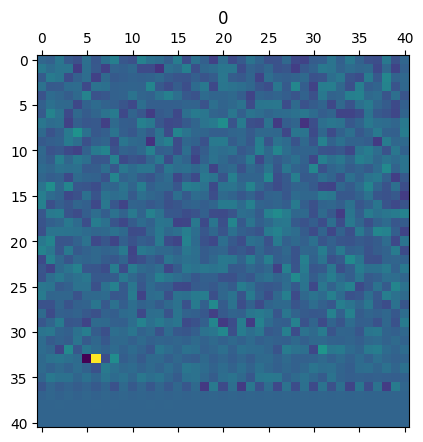

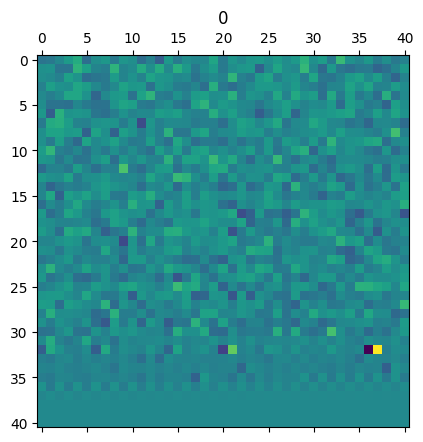

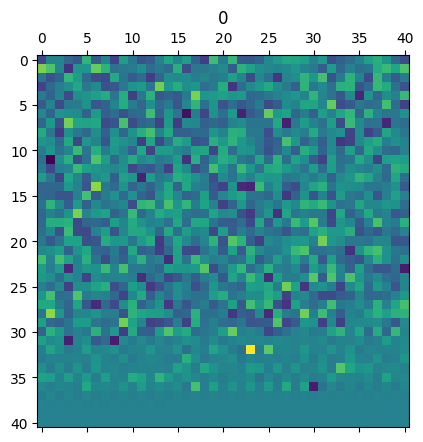

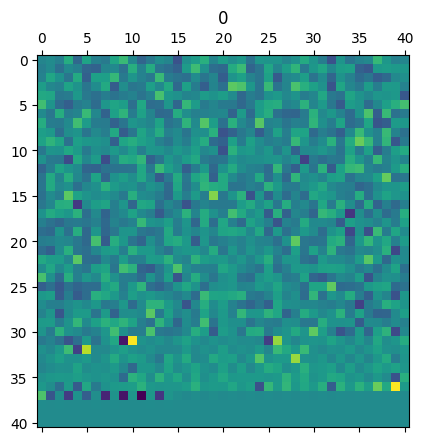

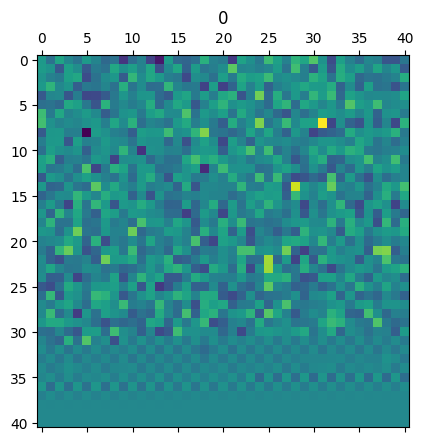

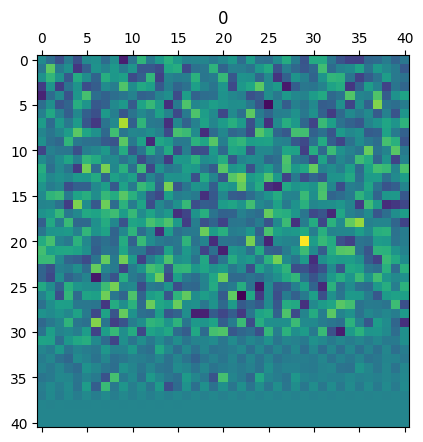

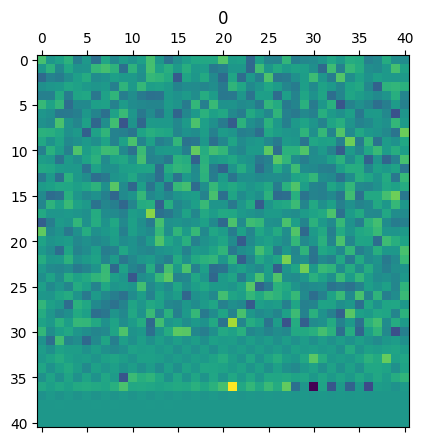

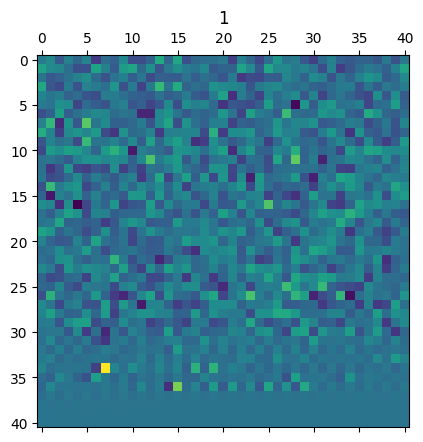

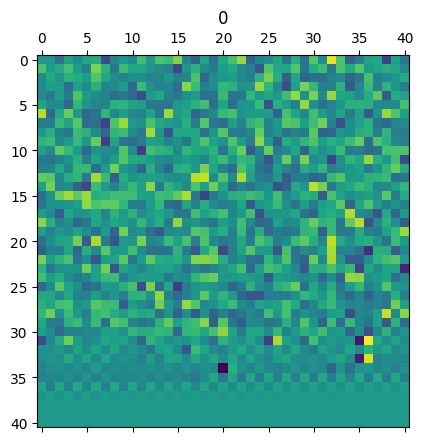

In [57]:
for i in range(30):
    plt.matshow(train_data[i])
    plt.title(train_labels[i])
    plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 41, 41, 8)         80        
                                                                 
 average_pooling2d_3 (Avera  (None, 20, 20, 8)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 20, 16)        1168      
                                                                 
 average_pooling2d_4 (Avera  (None, 10, 10, 16)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 32)        4640      
                                                                 
 average_pooling2d_5 (Avera  (None, 5, 5, 32)         

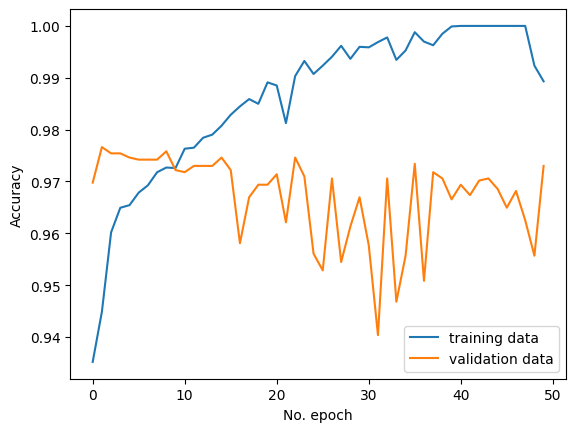

In [58]:
 model_trainning_saving([41,41],50,"esm_model_avocado_hass",train_data,train_labels,test_data,test_labels)